In [1]:
!pip install statsmodels --upgrade

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [21]:
#from google.colab import files
import io
import warnings
import sys
from numpy.linalg import LinAlgError
warnings.filterwarnings('ignore')
import pandas as pd
from pandas import read_excel, read_csv
from pandas import datetime
from matplotlib import pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
%matplotlib inline

In [4]:
#function to preprocess data
def preprocess(data):
  data['SKU id']=pd.Series([int(id[4:]) for id in data["SKU id"].values])
  data['Warehouse id']=pd.Series([int(id[3:]) for id in data["Warehouse id"].values])
  return data

In [31]:
#ARIMA
#For each SKU id, applying ARIMA model will give best possible predictions for some value of lag
#So, for each SKU id in each warehouse, we iterate over the allowed values of lag (here, 1 to 4) to find lag value giving best accuracy
#Finally, we store the min_mape and (predicted,expected) for the lag value giving best accuracy for a SKU id.

def arima_forecast(data):

  predictions_1, predictions_2, final_predictions_1, final_predictions_2 = [], [], [], []
  for tsize in range(1,3):
  
    pred_list = []
    for row in range(len(data)):

      min_mape = sys.float_info.max
      pred_ = []
      final_pred = 0.0
      rmse_ = 0.0

      for lag in range(1,3):

        predictions = []
        x = data.iloc[row,3:].values
        train, test = x[:-tsize], x[-tsize:]
        history = [i for i in train]
        model = ARIMA(history, order=(lag,1,0))
        model_fit = model.fit()

        for t in range(len(test)):
          
          try :
            output = model_fit.forecast()
            yhat = output[0]
            predictions.append(yhat)
            obs = test[t]
            history.append(obs)

          except LinAlgError:
            return predictions_1[:], predictions_2[:], final_predictions_1[:], final_predictions_2[:]

        output = model_fit.get_forecast(steps=1).predicted_mean
        predictions.append(output[0])
        mape = mean_absolute_percentage_error(test, predictions[:-1])
        rmse = sqrt(mean_squared_error(test, predictions[:-1]))

        if mape < min_mape :
          min_mape = mape
          pred_ = predictions[:]
          rmse_ = rmse
          
      pred_list.append(pred_[:])

    expected = list(data.iloc[:,-1])
  
    if tsize == 1:

      print("Size of test data :",tsize)
      for idx in range(len(pred_list)) :

        predicted = pred_list[idx][0]
        final_predicted = pred_list[idx][1]
        predictions_1.append(predicted)
        final_predictions_1.append(final_predicted)

      mape = mean_absolute_percentage_error(expected, predictions_1)
      rmse = sqrt(mean_squared_error(expected, predictions_1))
      print('MAPE : %.3f' % mape)
      print('RMSE : %.3f' % rmse)

    elif tsize == 2:

      print("Size of test data :",tsize)
      for idx in range(len(pred_list)) :

        predicted = pred_list[idx][1]
        final_predicted = pred_list[idx][2]
        predictions_2.append(predicted)
        final_predictions_2.append(final_predicted)

      mape = mean_absolute_percentage_error(expected, predictions_2)
      rmse = sqrt(mean_squared_error(expected, predictions_2))
      print('MAPE : %.3f' % mape)
      print('RMSE : %.3f' % rmse)

  return predictions_1[:], predictions_2[:], final_predictions_1[:], final_predictions_2[:]

In [29]:
def arima(data):

  wh = data.groupby('Warehouse id') 
  wh_dict = {}                             #separate dataframes for each warehouse
  for i in range(1,5):

    wh_data = wh.get_group(i)
    print('\n#### WAREHOUSE {} ####\n'.format(i))
    predictions_1, predictions_2, final_predictions_1, final_predictions_2 = arima_forecast(wh_data)
    wh_data_ = wh_data.copy()
    if len(predictions_1) != 0 :
      wh_data_['Predictions_Last1'] = predictions_1
      wh_data_['June-21_Last1'] = final_predictions_1
    if len(predictions_2) != 0 :
      wh_data_['Predictions_Last2'] = predictions_2
      wh_data_['June-21_Last2'] = final_predictions_2
    wh_dict[str(i)] = wh_data_

  return wh_dict

In [40]:
uploaded = files.upload()

Saving anomaly_ma.xlsx to anomaly_ma (1).xlsx


In [18]:
#MOVING AVERAGE
#df_ma = read_excel(io.BytesIO(uploaded['anomaly_ma.xlsx']))
df_ma = read_excel('anomaly_ma.xlsx')
df_ma.head()

,Warehouse id,Region,SKU id,2018-04-01 00:00:00,2018-05-01 00:00:00,2018-06-01 00:00:00,2018-07-01 00:00:00,2018-08-01 00:00:00,2018-09-01 00:00:00,2018-10-01 00:00:00,...,2020-08-01 00:00:00,2020-09-01 00:00:00,2020-10-01 00:00:00,2020-11-01 00:00:00,2020-12-01 00:00:00,2021-01-01 00:00:00,2021-02-01 00:00:00,2021-03-01 00:00:00,2021-04-01 00:00:00,2021-05-01 00:00:00
0,Wh-1,NORTH,SKU-1,27.0,13.0,30.0,14.0,22.0,8.0,8.0,...,12.0,8.0,8.0,8.0,8.0,8.0,14.0,16.000000,8.0,12.0
1,Wh-1,NORTH,SKU-2,88.0,28.0,127.0,130.0,58.0,10.0,7.0,...,16.0,7.0,7.0,7.0,7.0,7.0,13.0,43.000000,13.0,43.0
2,Wh-1,NORTH,SKU-3,6.0,6.0,6.0,6.0,6.0,6.0,6.0,...,8.0,6.0,6.0,6.0,6.0,6.0,6.0,8.000000,26.0,6.0
3,Wh-1,NORTH,SKU-4,162.0,184.0,110.0,172.0,90.0,40.0,18.0,...,82.0,78.0,38.0,18.0,22.0,28.0,36.0,148.666667,58.0,18.0
4,Wh-1,NORTH,SKU-5,171.0,402.0,627.0,615.0,300.0,417.0,141.0,...,468.0,216.0,75.0,6.0,30.0,66.0,141.0,699.000000,183.0,24.0


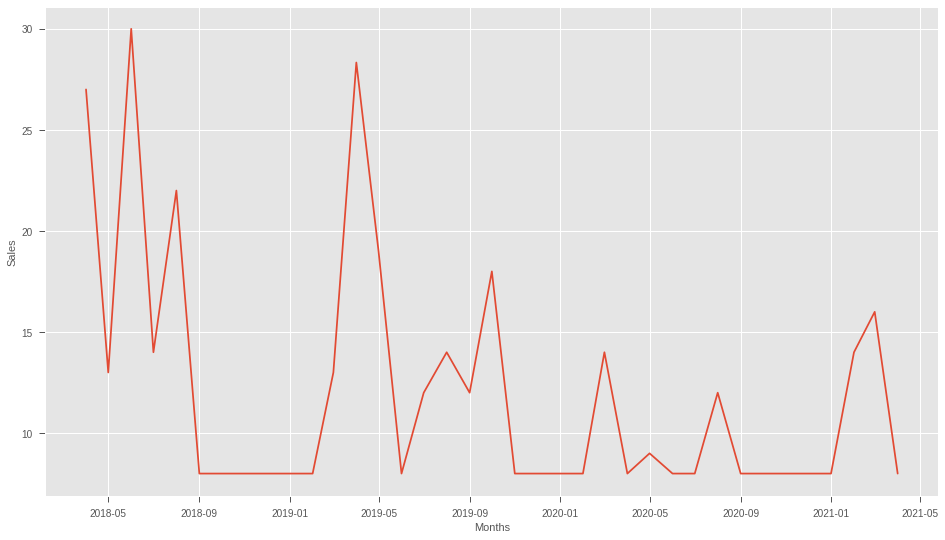

In [35]:
values = df_ma.iloc[0,1:-1]
plt.style.use('seaborn-notebook')
plt.figure(figsize=(16,9))
plt.xlabel('Months')
plt.ylabel('Sales')
plt.plot(values.index[2:],values.values[2:])

In [19]:
df_ma = preprocess(df_ma)

In [32]:
type_ = "IQR_MA"
wh_dict = arima(df_ma)


#### WAREHOUSE 1 ####

Size of test data : 1
MAPE : 4.627
RMSE : 475.686
Size of test data : 2
MAPE : 9.793
RMSE : 1341.417

#### WAREHOUSE 2 ####

Size of test data : 1
MAPE : 5.205
RMSE : 551.943
Size of test data : 2
MAPE : 8.199
RMSE : 744.663

#### WAREHOUSE 3 ####

Size of test data : 1
MAPE : 0.886
RMSE : 182.796
Size of test data : 2
MAPE : 1.943
RMSE : 204.367

#### WAREHOUSE 4 ####

Size of test data : 1
MAPE : 5.674
RMSE : 388.561
Size of test data : 2
MAPE : 7.476
RMSE : 652.932


In [33]:
wh_dict['4']

,Warehouse id,Region,SKU id,2018-04-01 00:00:00,2018-05-01 00:00:00,2018-06-01 00:00:00,2018-07-01 00:00:00,2018-08-01 00:00:00,2018-09-01 00:00:00,2018-10-01 00:00:00,...,2020-12-01 00:00:00,2021-01-01 00:00:00,2021-02-01 00:00:00,2021-03-01 00:00:00,2021-04-01 00:00:00,2021-05-01 00:00:00,Predictions_Last1,June-21_Last1,Predictions_Last2,June-21_Last2
753,4,SOUTH,1,142.000000,103.0,37.0,226.0,19.0,40.0,52.0,...,19.0,37.0,76.0,73.0,112.000000,19.0,97.482743,97.482743,61.752985,61.752985
754,4,SOUTH,2,99.333333,106.0,22.0,58.0,38.0,18.0,22.0,...,22.0,18.0,50.0,74.0,30.000000,50.0,48.022155,48.022155,51.606165,51.606165
755,4,SOUTH,3,15.000000,15.0,15.0,15.0,15.0,15.0,15.0,...,15.0,15.0,15.0,15.0,17.666667,15.0,16.372181,16.372181,15.000000,15.000000
756,4,SOUTH,4,196.000000,58.0,120.0,54.0,58.0,224.0,204.0,...,32.0,200.0,206.0,152.0,190.000000,64.0,185.339929,185.339929,158.597346,158.597346
757,4,SOUTH,5,250.000000,232.0,154.0,244.0,127.0,130.0,232.0,...,130.0,154.0,364.0,817.0,727.000000,40.0,554.028053,554.028053,730.643827,730.643827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,4,SOUTH,229,7.000000,7.0,7.0,7.0,7.0,7.0,7.0,...,135.0,239.0,295.0,7.0,7.000000,135.0,74.771193,74.771193,133.323661,133.323661
1035,4,SOUTH,230,49.000000,25.0,41.0,13.0,21.0,53.0,33.0,...,9.0,33.0,9.0,103.0,49.000000,9.0,59.335538,59.335538,51.389701,51.389701
1036,4,SOUTH,231,21.000000,13.0,13.0,21.0,29.0,21.0,21.0,...,13.0,21.0,13.0,13.0,13.000000,13.0,13.000000,13.000000,13.000000,13.000000
1037,4,SOUTH,232,15.000000,13.0,13.0,11.0,9.0,11.0,36.0,...,11.0,36.0,21.0,17.0,9.000000,9.0,12.790015,12.790015,18.947560,18.947560


In [ ]:
for i in range(len(wh_dict)):
  wh_data_ = wh_dict[str(i+1)]
  filename = ('ARIMA_'+type_+'_Predictions_W{}.csv').format(i+1)
  wh_data_.to_csv(filename)
  files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
uploaded = files.upload()

Saving Data_iqr_intersection.xlsx to Data_iqr_intersection (1).xlsx


In [ ]:
#IQR_INTERSECTION
df_iqr_int = read_excel(io.BytesIO(uploaded['Data_iqr_intersection.xlsx']))
df_iqr_int.head()

,Warehouse id,Region,SKU id,2018-04-01 00:00:00,2018-05-01 00:00:00,2018-06-01 00:00:00,2018-07-01 00:00:00,2018-08-01 00:00:00,2018-09-01 00:00:00,2018-10-01 00:00:00,...,2020-08-01 00:00:00,2020-09-01 00:00:00,2020-10-01 00:00:00,2020-11-01 00:00:00,2020-12-01 00:00:00,2021-01-01 00:00:00,2021-02-01 00:00:00,2021-03-01 00:00:00,2021-04-01 00:00:00,2021-05-01 00:00:00
0,Wh-1,NORTH,SKU-1,27.0,13.0,30.0,14.0,22,8.0,8.0,...,12.000000,8.0,8.0,8.0,8.0,8.0,14.0,16.000000,8.000000,12.0
1,Wh-1,NORTH,SKU-2,88.0,28.0,127.0,130.0,58,10.0,7.0,...,16.000000,7.0,7.0,7.0,7.0,7.0,13.0,43.000000,13.000000,43.0
2,Wh-1,NORTH,SKU-3,6.0,6.0,6.0,6.0,6,6.0,6.0,...,6.666667,6.0,6.0,6.0,6.0,6.0,6.0,13.333333,15.111111,6.0
3,Wh-1,NORTH,SKU-4,162.0,184.0,110.0,172.0,90,40.0,18.0,...,82.000000,78.0,38.0,18.0,22.0,28.0,36.0,352.000000,58.000000,18.0
4,Wh-1,NORTH,SKU-5,171.0,402.0,627.0,615.0,300,417.0,141.0,...,468.000000,216.0,75.0,6.0,30.0,66.0,141.0,699.000000,183.000000,24.0


In [ ]:
df_iqr_int = preprocess(df_iqr_int)

In [ ]:
type_ = "IQR_INT"
wh_dict = arima(df_iqr_int)


#### WAREHOUSE 1 ####

Size of test data : 1
MAPE : 5.915
RMSE : 526.320

#### WAREHOUSE 2 ####

Size of test data : 1
MAPE : 4.917
RMSE : 582.312

#### WAREHOUSE 3 ####

Size of test data : 1
MAPE : 0.923
RMSE : 183.988

#### WAREHOUSE 4 ####

Size of test data : 1
MAPE : 5.440
RMSE : 418.952


In [ ]:
wh_dict['4'].head()

,Warehouse id,Region,SKU id,2018-04-01 00:00:00,2018-05-01 00:00:00,2018-06-01 00:00:00,2018-07-01 00:00:00,2018-08-01 00:00:00,2018-09-01 00:00:00,2018-10-01 00:00:00,...,2020-09-01 00:00:00,2020-10-01 00:00:00,2020-11-01 00:00:00,2020-12-01 00:00:00,2021-01-01 00:00:00,2021-02-01 00:00:00,2021-03-01 00:00:00,2021-04-01 00:00:00,2021-05-01 00:00:00,Predictions_Last1
753,4,SOUTH,1,142.0,103.0,37.0,226.0,19,40.0,52.0,...,911.000000,1106.333333,34.0,19.0,37.0,76.0,73.0,112.000000,19.0,110
754,4,SOUTH,2,170.0,106.0,22.0,58.0,38,18.0,22.0,...,70.000000,10.000000,38.0,22.0,18.0,50.0,74.0,30.000000,50.0,44
755,4,SOUTH,3,15.0,15.0,15.0,15.0,15,15.0,15.0,...,15.000000,15.000000,15.0,15.0,15.0,15.0,15.0,17.666667,15.0,16
756,4,SOUTH,4,196.0,58.0,120.0,54.0,58,224.0,204.0,...,1709.333333,925.111111,112.0,32.0,200.0,206.0,152.0,190.000000,64.0,184
757,4,SOUTH,5,250.0,232.0,154.0,244.0,127,130.0,232.0,...,1057.000000,730.000000,178.0,130.0,154.0,364.0,817.0,727.000000,40.0,554


In [ ]:
for i in range(len(wh_dict)):
  wh_data_ = wh_dict[str(i+1)]
  filename = ('ARIMA_'+type_+'_Predictions_W{}.csv').format(i+1)
  wh_data_.to_csv(filename)
  files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
uploaded = files.upload()

Saving Data_iqr_log.xlsx to Data_iqr_log (1).xlsx


In [ ]:
#IQR_INTERSECTION
df_iqr_log = read_excel(io.BytesIO(uploaded['Data_iqr_log.xlsx']))
df_iqr_log.head()

,Warehouse id,Region,SKU id,2018-04-01 00:00:00,2018-05-01 00:00:00,2018-06-01 00:00:00,2018-07-01 00:00:00,2018-08-01 00:00:00,2018-09-01 00:00:00,2018-10-01 00:00:00,...,2020-08-01 00:00:00,2020-09-01 00:00:00,2020-10-01 00:00:00,2020-11-01 00:00:00,2020-12-01 00:00:00,2021-01-01 00:00:00,2021-02-01 00:00:00,2021-03-01 00:00:00,2021-04-01 00:00:00,2021-05-01 00:00:00
0,Wh-1,NORTH,SKU-1,27.0,13.0,30.0,14.0,22.0,8.0,8.0,...,12.000000,8.0,8.0,8.0,8.0,8.0,14.0,16.000000,8.000000,12.0
1,Wh-1,NORTH,SKU-2,88.0,28.0,127.0,130.0,58.0,10.0,7.0,...,16.000000,7.0,7.0,7.0,7.0,7.0,13.0,43.000000,13.000000,43.0
2,Wh-1,NORTH,SKU-3,6.0,6.0,6.0,6.0,6.0,6.0,6.0,...,6.666667,6.0,6.0,6.0,6.0,6.0,6.0,13.333333,15.111111,6.0
3,Wh-1,NORTH,SKU-4,162.0,184.0,110.0,172.0,90.0,40.0,18.0,...,82.000000,78.0,38.0,18.0,22.0,28.0,36.0,352.000000,58.000000,18.0
4,Wh-1,NORTH,SKU-5,171.0,402.0,627.0,615.0,300.0,417.0,141.0,...,468.000000,216.0,75.0,6.0,30.0,66.0,141.0,699.000000,183.000000,24.0


In [ ]:
df_iqr_log = preprocess(df_iqr_log)

In [ ]:
type_ = "IQR_LOG"
wh_dict = arima(df_iqr_log)


#### WAREHOUSE 1 ####

Size of test data : 1
MAPE : 4.120
RMSE : 522.684

#### WAREHOUSE 2 ####

Size of test data : 1
MAPE : 3.895
RMSE : 474.511

#### WAREHOUSE 3 ####

Size of test data : 1
MAPE : 0.919
RMSE : 174.623

#### WAREHOUSE 4 ####

Size of test data : 1
MAPE : 3.428
RMSE : 353.350


In [ ]:
wh_dict['4'].head()

,Warehouse id,Region,SKU id,2018-04-01 00:00:00,2018-05-01 00:00:00,2018-06-01 00:00:00,2018-07-01 00:00:00,2018-08-01 00:00:00,2018-09-01 00:00:00,2018-10-01 00:00:00,...,2020-09-01 00:00:00,2020-10-01 00:00:00,2020-11-01 00:00:00,2020-12-01 00:00:00,2021-01-01 00:00:00,2021-02-01 00:00:00,2021-03-01 00:00:00,2021-04-01 00:00:00,2021-05-01 00:00:00,Predictions_Last1
753,4,SOUTH,1,142.0,103.0,37.0,226.0,19.0,40.0,52.0,...,911.000000,1106.333333,34.0,19.0,37.0,76.0,73.0,112.000000,19.0,110
754,4,SOUTH,2,170.0,106.0,22.0,58.0,38.0,18.0,22.0,...,70.000000,10.000000,38.0,22.0,18.0,50.0,74.0,30.000000,50.0,44
755,4,SOUTH,3,15.0,15.0,15.0,15.0,15.0,15.0,15.0,...,15.000000,15.000000,15.0,15.0,15.0,15.0,15.0,17.666667,15.0,16
756,4,SOUTH,4,196.0,58.0,120.0,54.0,58.0,224.0,204.0,...,1709.333333,925.111111,112.0,32.0,200.0,206.0,152.0,190.000000,64.0,185
757,4,SOUTH,5,250.0,232.0,154.0,244.0,127.0,130.0,232.0,...,1057.000000,730.000000,178.0,130.0,154.0,364.0,817.0,727.000000,40.0,533


In [ ]:
for i in range(len(wh_dict)):
  wh_data_ = wh_dict[str(i+1)]
  filename = ('ARIMA_'+type_+'_Predictions_W{}.csv').format(i+1)
  wh_data_.to_csv(filename)
  files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
uploaded = files.upload()

Saving Data_iqr_normal.xlsx to Data_iqr_normal.xlsx


In [ ]:
#IQR_NORMAL
df_iqr_norm = read_excel(io.BytesIO(uploaded['Data_iqr_normal.xlsx']))
df_iqr_norm.head()

,Warehouse id,Region,SKU id,2018-04-01 00:00:00,2018-05-01 00:00:00,2018-06-01 00:00:00,2018-07-01 00:00:00,2018-08-01 00:00:00,2018-09-01 00:00:00,2018-10-01 00:00:00,...,2020-08-01 00:00:00,2020-09-01 00:00:00,2020-10-01 00:00:00,2020-11-01 00:00:00,2020-12-01 00:00:00,2021-01-01 00:00:00,2021-02-01 00:00:00,2021-03-01 00:00:00,2021-04-01 00:00:00,2021-05-01 00:00:00
0,Wh-1,NORTH,SKU-1,23.333333,13.0,19.0,14.0,22.0,8.0,8.0,...,12.000000,8.0,8.0,8.0,8.0,8.0,14.0,16.000000,8.000000,12.0
1,Wh-1,NORTH,SKU-2,88.000000,28.0,127.0,130.0,58.0,10.0,7.0,...,16.000000,7.0,7.0,7.0,7.0,7.0,13.0,43.000000,13.000000,43.0
2,Wh-1,NORTH,SKU-3,6.000000,6.0,6.0,6.0,6.0,6.0,6.0,...,6.666667,6.0,6.0,6.0,6.0,6.0,6.0,13.333333,15.111111,6.0
3,Wh-1,NORTH,SKU-4,162.000000,184.0,110.0,172.0,90.0,40.0,18.0,...,82.000000,78.0,38.0,18.0,22.0,28.0,36.0,148.666667,58.000000,18.0
4,Wh-1,NORTH,SKU-5,171.000000,402.0,627.0,615.0,300.0,417.0,141.0,...,468.000000,216.0,75.0,6.0,30.0,66.0,141.0,699.000000,183.000000,24.0


In [ ]:
df_iqr_norm = preprocess(df_iqr_norm)

In [ ]:
type_ = "IQR_NORM"
wh_dict = arima(df_iqr_norm)


#### WAREHOUSE 1 ####

Size of test data : 1
MAPE : 5.603
RMSE : 321.738

#### WAREHOUSE 2 ####

Size of test data : 1
MAPE : 4.428
RMSE : 542.087

#### WAREHOUSE 3 ####

Size of test data : 1
MAPE : 0.859
RMSE : 174.741

#### WAREHOUSE 4 ####

Size of test data : 1
MAPE : 4.375
RMSE : 275.916


In [ ]:
wh_dict['4'].head()

,Warehouse id,Region,SKU id,2018-04-01 00:00:00,2018-05-01 00:00:00,2018-06-01 00:00:00,2018-07-01 00:00:00,2018-08-01 00:00:00,2018-09-01 00:00:00,2018-10-01 00:00:00,...,2020-09-01 00:00:00,2020-10-01 00:00:00,2020-11-01 00:00:00,2020-12-01 00:00:00,2021-01-01 00:00:00,2021-02-01 00:00:00,2021-03-01 00:00:00,2021-04-01 00:00:00,2021-05-01 00:00:00,Predictions_Last1
753,4,SOUTH,1,142.000000,103.0,37.0,94.0,19.0,40.0,52.0,...,911.000000,1106.333333,34.0,19.0,37.0,76.0,73.0,112.000000,19.0,111
754,4,SOUTH,2,99.333333,106.0,22.0,58.0,38.0,18.0,22.0,...,70.000000,10.000000,38.0,22.0,18.0,50.0,74.0,30.000000,50.0,48
755,4,SOUTH,3,15.000000,15.0,15.0,15.0,15.0,15.0,15.0,...,15.000000,15.000000,15.0,15.0,15.0,15.0,15.0,17.666667,15.0,16
756,4,SOUTH,4,196.000000,58.0,120.0,54.0,58.0,224.0,204.0,...,1709.333333,925.111111,112.0,32.0,200.0,206.0,152.0,190.000000,64.0,184
757,4,SOUTH,5,250.000000,232.0,154.0,244.0,127.0,130.0,232.0,...,1057.000000,655.000000,178.0,130.0,154.0,364.0,636.0,467.666667,40.0,377


In [ ]:
for i in range(len(wh_dict)):
  wh_data_ = wh_dict[str(i+1)]
  filename = ('ARIMA_'+type_+'_Predictions_W{}.csv').format(i+1)
  wh_data_.to_csv(filename)
  files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>